# Combine Twitter Posts

## Step 1 - Format the Play by Play Tweet Data

In [102]:
import pandas as pd
from datetime import timedelta

df = pd.read_csv('../../data/all_pbp_tweets.tar.gz')

# Drop the rows that are just repeats of the header
df = df.drop(df.loc[df['created_at'] == 'created_at'].index)

# Drop columns that don't contain meaninful data
df = df.drop(['location','time_zone'], axis=1)

# Convert created_at to datetime
df['UTC_Datetime'] = pd.to_datetime(df['created_at'])

# Rename column to tweet id and make it the index
df = df.rename(columns={'cardinals_pbp_tweets.csv':'tweet_id'}).set_index('tweet_id')

# make the tweet_id numeric
df.index = pd.to_numeric(df.index)

# Drop a single annoying NA row
df = df.loc[df.index.dropna()] # Drop this annoying

# Make year and time columns
df['time'] = df['UTC_Datetime'].apply(lambda x: x.time())
df['date'] = df['UTC_Datetime'].apply(lambda x: x.date())

# Sort by the timestamp
df = df.sort_values('UTC_Datetime')

# Reorder the columns in the dataframe
df = df[['UTC_Datetime','date','time','screen_name','source','text']]

# Only Games from 2017 Season and name pbptweets
df = df.loc[df['UTC_Datetime'] > '04-Sep-2017']

pbptweets = df.copy()

print("PBP Tweets length:", len(pbptweets))

pbptweets['gamedate'] = pbptweets['UTC_Datetime'].apply(lambda x: (x - timedelta(hours=12)).date())

# Create Team Name Columns
pbptweets['Team1'] = pbptweets['source'].apply(lambda x: x.split(' ')[0])
pbptweets['Team2'] = pbptweets['source'].apply(lambda x: x.split(' ')[0])
pbptweets = pbptweets.replace(to_replace='Buccaneer', value='Buccaneers')


pbptweets = pbptweets.reset_index()

winpct = pd.read_csv('../../data/All_Games_Win_Pct.csv')

# Call the play text the same thing as the other dataframe
winpct['text'] = winpct['playtext']

# Convert date to datetime
winpct['gamedate'] = pd.to_datetime(winpct['Game Date'])

winpct['Team1'] = winpct['Game Title'].apply(lambda x: x.split(' ')[0])
winpct['Team2'] = winpct['Game Title'].apply(lambda x: x.split(' ')[2])

winpct['Game Title Date']  = winpct.apply(lambda x: x['Game Title'] + ' ' + x['gamedate'].strftime('%Y-%m-%d'), axis =1)

# Make both dates a pandas datetime
winpct['gamedate'] = pd.to_datetime(winpct['gamedate'])
pbptweets['gamedate'] = pd.to_datetime(pbptweets['gamedate'])

# Create List of Games
gamelist = winpct.drop_duplicates(subset='Game Title Date')
gamelist = gamelist[['Game Title Date','Team1','Team2','gamedate']].reset_index().drop('index', axis=1)
# Add missing Games

tweetmerge = pbptweets.merge(gamelist, how='inner', on=['gamedate','Team1'])
tweetmerge2 = pbptweets.merge(gamelist, how='inner', on=['gamedate','Team2'])

pbptweets2 = pd.concat([tweetmerge, tweetmerge2])

print("PBP Tweets length after merge with game name:", len(pbptweets2))

pbptweets = pbptweets.set_index('tweet_id')
pbptweets2 = pbptweets2.set_index('tweet_id')

pbptweets2 = pbptweets2[['Game Title Date','UTC_Datetime','gamedate','screen_name','text']].copy()

def clean_tweet(tweettext):
    tweettext = tweettext.replace('1/2 ','')
    tweettext = tweettext.replace('2/2 ','SPLIT_TWEET-')
    tweettext = tweettext.replace('1/3 ','')
    tweettext = tweettext.replace('2/3 ','SPLIT_TWEET-')
    tweettext = tweettext.replace('3/3 ','SPLIT_TWEET-')
    tweettext = tweettext.replace('1/4 ','')
    tweettext = tweettext.replace('2/4 ','SPLIT_TWEET-')
    tweettext = tweettext.replace('3/4 ','SPLIT_TWEET-')
    tweettext = tweettext.replace('4/4 ','SPLIT_TWEET-')
    return tweettext

pbptweets2['text_cleaned'] = pbptweets2['text'].apply(clean_tweet)

pbptweets2['Game_and_Tweet'] = pbptweets2['Game Title Date'] + pbptweets2['text_cleaned']

tweetsraw = pd.DataFrame(pbptweets2[['Game_and_Tweet','UTC_Datetime','Game Title Date']])

winpct['Game_and_Tweet'] = winpct['Game Title Date'] + winpct['text']
winpctraw = winpct[['Game_and_Tweet','homeWinPercentage','playId','Game Title Date','playnum']]

winpctraw = winpctraw.sort_values('playnum')

PBP Tweets length: 79409
PBP Tweets length after merge with game name: 78026


# Use DiffLib To Match
(This is too slow to work)

In [101]:
import difflib

def get_matches(row):
    print(row['Game Title Date'])
    possabilities = tweetsraw.loc[tweetsraw['Game Title Date'] == row['Game Title Date']]
    
    matched = difflib.get_close_matches(word=row['Game_and_Tweet'],
                                        possibilities=tweetsraw['Game_and_Tweet'], cutoff=0.6)
    print(row['Game_and_Tweet'])
    
    #print(matched)
    if len(matched) == 0:
        tweet_id = ['No Match']
        print('No Match')
    else:
        print(matched[0])
        tweet_ids = tweetsraw.loc[tweetsraw['Game_and_Tweet'] == matched[0]]
        tweet_id = tweet_ids.head(1).index.values[0]
    return tweet_id

In [376]:
# Take one game as an example
df = winpctraw.loc[winpctraw['Game Title Date'] == 'Jaguars vs. Patriots  2018-01-21']
df = df.set_index('playnum')
df = df.sort_index()
df2 = tweetsraw.loc[tweetsraw['Game Title Date'] == 'Jaguars vs. Patriots  2018-01-21']

# Use FuzzyWuzzy to Match

In [380]:
# Take one game as an example
df = winpctraw.loc[winpctraw['Game Title Date'] == 'Jaguars vs. Patriots  2018-01-21']
df = df.set_index('playnum')
df = df.sort_index()
df2 = tweetsraw.loc[tweetsraw['Game Title Date'] == 'Jaguars vs. Patriots  2018-01-21']

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

match_twitterids = []

df2_index = df2.index
df2_temp = df2.copy()
matches = []
matchscores = []
matchindexes = []

for row in df.itertuples():
    print('Play:    ',row[1])
    match, score, matchindex = process.extractOne(row[1], df2_temp['Game_and_Tweet'])
    matches.append(match)
    matchscores.append(score)
    matchindexes.append(matchindex)
    
    print('Tweet:   ',match)
    print('============={}============'.format(score))

Play:     Jaguars vs. Patriots  2018-01-21J.Lambo kicks 65 yards from JAX 35 to end zone, Touchback.
Tweet:    Jaguars vs. Patriots  2018-01-21J.Lambo kicks 65 yards from JAX 35 to end zone Touchback. #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21(15:00) (Shotgun) T.Brady pass short right to D.Lewis to NE 30 for 5 yards (T.Smith). NE 12-Brady 36th career postseason game, extends his NFL record. NE 12-Brady 36th career postseason QB start, extends his NFL record.
Tweet:    Jaguars vs. Patriots  2018-01-21(12:33) (Shotgun) T.Brady pass short right to C.Hogan pushed ob at JAX 30 for 3 yards (J.Ramsey). #NEvsJAX
=============86============
Play:     Jaguars vs. Patriots  2018-01-21(14:18) (Shotgun) T.Brady pass deep right to B.Cooks to JAX 39 for 31 yards (T.Smith).
Tweet:    Jaguars vs. Patriots  2018-01-21Timeout #1 by NE at 11:49. #NEvsJAX
=============86============
Play:     Jaguars vs. Patriots  2018-01-21(13:47) (No Huddle, Shotgun) T.Brady scrambles

Tweet:    Jaguars vs. Patriots  2018-01-21(1:36) (Shotgun) L.Fournette up the middle to NE 43 for 6 yards (E.Roberts L.Guy). #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21(1:01) L.Fournette up the middle to NE 39 for 4 yards (J.Harrison).
Tweet:    Jaguars vs. Patriots  2018-01-21(1:01) L.Fournette up the middle to NE 39 for 4 yards (J.Harrison). #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21(:23) B.Bortles pass short right to K.Cole to NE 28 for 11 yards (S.Gilmore).
Tweet:    Jaguars vs. Patriots  2018-01-21(:23) B.Bortles pass short right to K.Cole to NE 28 for 11 yards (S.Gilmore). #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21END QUARTER 1
Tweet:    Jaguars vs. Patriots  2018-01-21END QUARTER 1 #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21(15:00) B.Bortles pass short right to C.Grant pushed ob at NE 4 for 24 yards (D.McCourty).
Tweet:    Jaguars vs. 

Tweet:    Jaguars vs. Patriots  2018-01-21(5:26) (Shotgun) L.Fournette up the middle to JAX 26 for 1 yard (https://t.co/ZjV1xSJ29R R.Jean Francois). #NEvsJAX
=============91============
Play:     Jaguars vs. Patriots  2018-01-21(4:51) (Shotgun) L.Fournette up the middle to JAX 27 for 1 yard (M.Brown).
Tweet:    Jaguars vs. Patriots  2018-01-21(4:51) (Shotgun) L.Fournette up the middle to JAX 27 for 1 yard (M.Brown). #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21(4:11) (Shotgun) B.Bortles pass deep right to K.Cole pushed ob at NE 47 for 26 yards (M.Butler).
Tweet:    Jaguars vs. Patriots  2018-01-21(4:11) (Shotgun) B.Bortles pass deep right to K.Cole pushed ob at NE 47 for 26 yards (M.Butler). #NEvsJAX
=============96============
Play:     Jaguars vs. Patriots  2018-01-21(3:52) L.Fournette up the middle to NE 45 for 2 yards (K.Van Noy). PENALTY on JAX, Illegal Shift, 5 yards, enforced at NE 47 - No Play.
Tweet:    Jaguars vs. Patriots  2018-01-21(3:52) L

Tweet:    Jaguars vs. Patriots  2018-01-21(11:52) L.Fournette up the middle to NE 39 for 3 yards (L.Guy K.Van Noy). #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21(11:13) L.Fournette left guard to NE 36 for 3 yards (L.Guy, T.Flowers).
Tweet:    Jaguars vs. Patriots  2018-01-21(11:13) L.Fournette left guard to NE 36 for 3 yards (L.Guy https://t.co/ZjV1xSJ29R). #NEvsJAX
=============91============
Play:     Jaguars vs. Patriots  2018-01-21(10:33) (Shotgun) B.Bortles pass incomplete short right to M.Lee (T.Flowers).
Tweet:    Jaguars vs. Patriots  2018-01-21(6:34) (Shotgun) B.Bortles pass incomplete short right to M.Lewis. #NEvsJAX
=============91============
Play:     Jaguars vs. Patriots  2018-01-21(10:28) J.Lambo 54 yard field goal is GOOD, Center-C.Holba, Holder-B.Nortman.
Tweet:    Jaguars vs. Patriots  2018-01-21(10:28) J.Lambo 54 yard field goal is GOOD Center-C.Holba Holder-B.Nortman. #NEvsJAX
=============95============
Play:     Jaguars vs. Patrio

Tweet:    Jaguars vs. Patriots  2018-01-21(14:56) J.Lambo 43 yard field goal is GOOD Center-C.Holba Holder-B.Nortman. #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21J.Lambo kicks 65 yards from JAX 35 to end zone, Touchback.
Tweet:    Jaguars vs. Patriots  2018-01-21J.Lambo kicks 65 yards from JAX 35 to end zone Touchback. #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21(14:52) D.Lewis left end to NE 27 for 2 yards (T.Smith).
Tweet:    Jaguars vs. Patriots  2018-01-21(14:52) D.Lewis left end to NE 27 for 2 yards (T.Smith). #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21(14:19) (Shotgun) T.Brady pass deep left to B.Cooks ran ob at NE 45 for 18 yards.
Tweet:    Jaguars vs. Patriots  2018-01-21(14:19) (Shotgun) T.Brady pass deep left to B.Cooks ran ob at NE 45 for 18 yards. #NEvsJAX
=============96============
Play:     Jaguars vs. Patriots  2018-01-21(13:53) (Shotgun) D.Amendola pass short left 

Tweet:    Jaguars vs. Patriots  2018-01-21(6:00) R.Allen punts 35 yards to JAX 10 Center-J.Cardona fair catch by D.Westbrook. #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21(5:53) (Shotgun) L.Fournette up the middle to JAX 9 for -1 yards (P.Chung).
Tweet:    Jaguars vs. Patriots  2018-01-21(5:53) (Shotgun) L.Fournette up the middle to JAX 9 for -1 yards (P.Chung). #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21(5:23) B.Bortles pass incomplete deep left to A.Hurns (E.Rowe).
Tweet:    Jaguars vs. Patriots  2018-01-21(5:23) B.Bortles pass incomplete deep left to A.Hurns (E.Rowe). #NEvsJAX
=============95============
Play:     Jaguars vs. Patriots  2018-01-21(5:13) (Shotgun) B.Bortles pass incomplete short middle to K.Cole [T.Flowers].
Tweet:    Jaguars vs. Patriots  2018-01-21(5:13) (Shotgun) B.Bortles pass incomplete short middle to K.Cole [https://t.co/ZjV1xSJ29R]. #NEvsJAX
=============91============
Play:     Jaguars vs. 

In [382]:
df['Matches'] = matches
df['Match Score'] = matchscores
df['MatchIndexes'] = matchindexes

In [391]:
df = df.merge(df2, how='left', left_on='MatchIndexes', right_index=True)

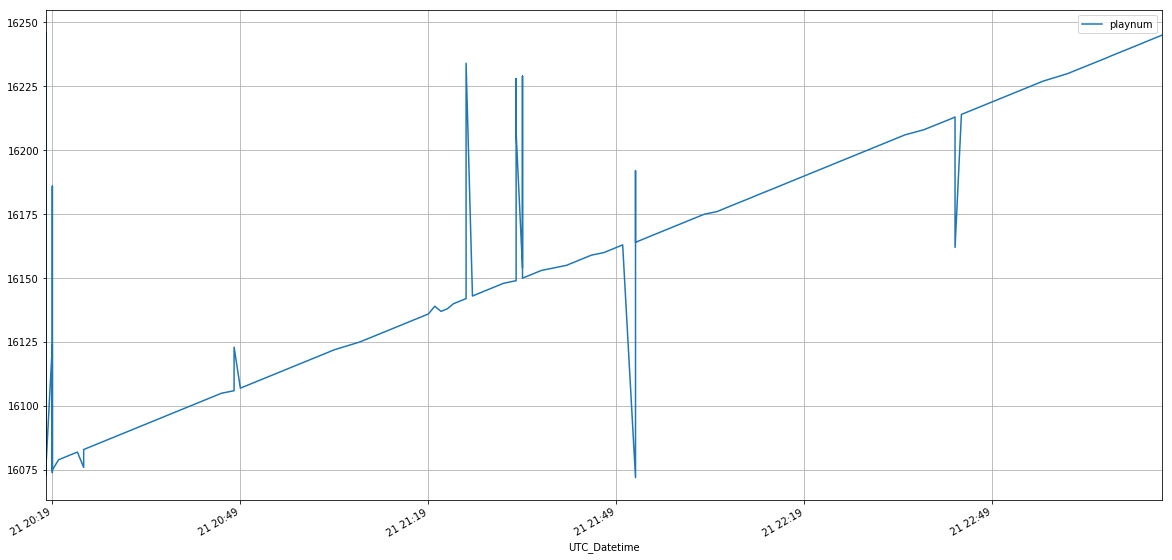

In [411]:
%matplotlib inline

df['playnum'] = df.index
df.plot(x='UTC_Datetime', y='playnum', figsize=(20,10), grid=True)

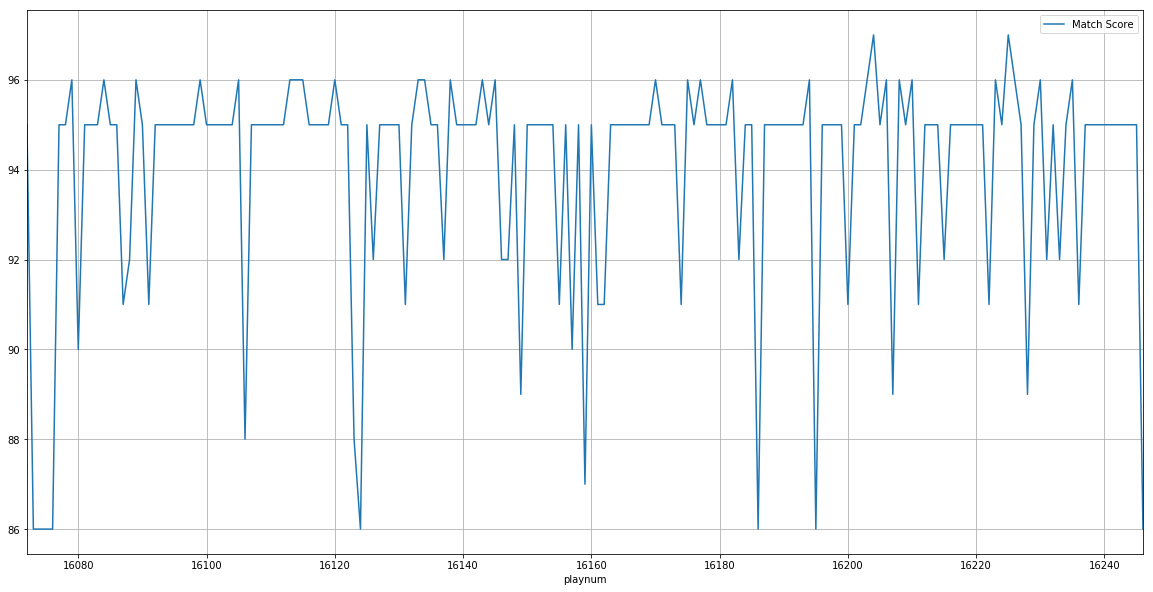

In [412]:
df.plot(x='playnum', y=['Match Score'], figsize=(20,10), grid=True) 

In [400]:
df.to_csv('PatsJags_Match_test.csv')

In [413]:
df2.to_csv('PatsJagsMatch2.csv')

In [422]:
pbptweets2.head()

,Game Title Date,UTC_Datetime,gamedate,screen_name,text,text_cleaned,Game_and_Tweet
tweet_id,,,,,,,
9.059546e+17,Chiefs vs. Patriots 2017-09-07,2017-09-08 00:43:00,2017-09-07,chiefs_pbp,C.Santos kicks 64 yards from KC 35 to NE 1. D....,C.Santos kicks 64 yards from KC 35 to NE 1. D....,Chiefs vs. Patriots 2017-09-07C.Santos kicks ...
9.059548e+17,Chiefs vs. Patriots 2017-09-07,2017-09-08 00:44:01,2017-09-07,chiefs_pbp,1/2 (14:55) NE 12-Brady 18th season as Patriot...,(14:55) NE 12-Brady 18th season as Patriots QB...,Chiefs vs. Patriots 2017-09-07(14:55) NE 12-B...
9.059548e+17,Chiefs vs. Patriots 2017-09-07,2017-09-08 00:44:01,2017-09-07,chiefs_pbp,2/2 T.Brady pass incomplete deep left to D.All...,T.Brady pass incomplete deep left to D.Allen. ...,Chiefs vs. Patriots 2017-09-07T.Brady pass in...
9.059548e+17,Chiefs vs. Patriots 2017-09-07,2017-09-08 00:44:02,2017-09-07,chiefs_pbp,(14:49) T.Brady pass short right to R.Burkhead...,(14:49) T.Brady pass short right to R.Burkhead...,Chiefs vs. Patriots 2017-09-07(14:49) T.Brady...
9.059551e+17,Chiefs vs. Patriots 2017-09-07,2017-09-08 00:45:00,2017-09-07,chiefs_pbp,(14:14) (Shotgun) J.White left guard to NE 43 ...,(14:14) (Shotgun) J.White left guard to NE 43 ...,Chiefs vs. Patriots 2017-09-07(14:14) (Shotgu...


In [425]:
pbptweets2[['Game Title Date','text_cleaned','UTC_Datetime']].sort_values(['Game Title Date','UTC_Datetime']).to_csv('../../data/All_tweets_Feb17.csv')

In [421]:
winpct[['playnum','playId','Game Title Date','text','homeWinPercentage']].sort_values(['Game Title Date','playnum']).to_csv('../../data/All_plays_Feb17.csv')

# See Which Tweets have Bad Timestamps

I've noticed for some of the games the tweets have the same timestamp. So they won't be useable for this project. Lets see which Tweets are actually useable.

In [12]:
import numpy as np

In [26]:
tweetsgrouped = tweetsraw[['UTC_Datetime','Game Title Date']].groupby('Game Title Date')

In [100]:
tweetsandcounts = pd.DataFrame(columns=['Game','Start','End','Duration'])
#tweetsandcounts = tweetsandcounts.reset_index()

count = 0
for i, d in tweetsgrouped:
    #print('--------------------------')
    #print(i)
    #d['Rounded_Minute'] = np.array(d['UTC_Datetime'], dtype='datetime64[m]')
    #agged = d.groupby('Rounded_Minute').count()
    #agged.plot()
    mindate = d['UTC_Datetime'].min()
    maxdate = d['UTC_Datetime'].max()
    gamedur = d['UTC_Datetime'].max()-d['UTC_Datetime'].min()
    #print( d['UTC_Datetime'].max()-d['UTC_Datetime'].min())
    #print(d['UTC_Datetime'].max(),'to',d['UTC_Datetime'].min())
    #d['UTC_Datetime'].hist()
    #if count == 200:
    #    break
    tweetsandcounts.loc[int(count)] = [i,mindate,maxdate,gamedur]
    count += 1

In [99]:
tweetsandcounts.to_csv('tweetgameduration.csv')

# Chiefs vs. Patriots  2017-09-07

In [103]:
# Take one game as an example
df = winpctraw.loc[winpctraw['Game Title Date'] == 'Chiefs vs. Patriots  2017-09-07']
df = df.set_index('playnum')
df = df.sort_index()
df2 = tweetsraw.loc[tweetsraw['Game Title Date'] == 'Chiefs vs. Patriots  2017-09-07']

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

match_twitterids = []

df2_index = df2.index
df2_temp = df2.copy()
matches = []
matchscores = []
matchindexes = []

for row in df.itertuples():
    print('Play:    ',row[1])
    match, score, matchindex = process.extractOne(row[1], df2_temp['Game_and_Tweet'])
    matches.append(match)
    matchscores.append(score)
    matchindexes.append(matchindex)
    
    print('Tweet:   ',match)
    print('============={}============'.format(score))

Play:     Chiefs vs. Patriots  2017-09-07C.Santos kicks 64 yards from KC 35 to NE 1. D.Lewis to NE 27 for 26 yards (K.Pierre-Louis, D.Harris).
Tweet:    Chiefs vs. Patriots  2017-09-07C.Santos kicks 64 yards from KC 35 to NE 1. D.Lewis to NE 27 for 26 yards (K.Pierre-Louis D.Harris). #NEvsKC
=============96============
Play:     Chiefs vs. Patriots  2017-09-07(14:55) T.Brady pass incomplete deep left to D.Allen.
Tweet:    Chiefs vs. Patriots  2017-09-07(11:53) T.Brady pass incomplete deep left to D.Allen [J.Houston]. #NEvsKC
=============91============
Play:     Chiefs vs. Patriots  2017-09-07(14:49) T.Brady pass short right to R.Burkhead pushed ob at NE 35 for 8 yards (R.Parker).
Tweet:    Chiefs vs. Patriots  2017-09-07(14:49) T.Brady pass short right to R.Burkhead pushed ob at NE 35 for 8 yards (R.Parker). #NEvsKC
=============96============
Play:     Chiefs vs. Patriots  2017-09-07(14:14) (Shotgun) J.White left guard to NE 43 for 8 yards (R.Parker, D.Johnson).
Tweet:    Chiefs vs. 

Tweet:    Chiefs vs. Patriots  2017-09-07(5:51) (Shotgun) A.Smith pass short middle to A.Wilson to NE 38 for 3 yards (M.Brown). #NEvsKC
=============96============
Play:     Chiefs vs. Patriots  2017-09-07(5:13) (Shotgun) A.Smith pass short middle to T.Hill to NE 27 for 11 yards (P.Chung).
Tweet:    Chiefs vs. Patriots  2017-09-07(5:13) (Shotgun) A.Smith pass short middle to T.Hill to NE 27 for 11 yards (P.Chung). #NEvsKC
=============96============
Play:     Chiefs vs. Patriots  2017-09-07(4:31) (Shotgun) A.Smith pass short right to C.Conley pushed ob at NE 9 for 18 yards (K.Van Noy).
Tweet:    Chiefs vs. Patriots  2017-09-07(4:31) (Shotgun) A.Smith pass short right to C.Conley pushed ob at NE 9 for 18 yards (K.Van Noy). #NEvsKC
=============96============
Play:     Chiefs vs. Patriots  2017-09-07(3:56) (Shotgun) A.Smith pass incomplete short right. thrown away from outside the pocket
Tweet:    Chiefs vs. Patriots  2017-09-07(6:14) (Shotgun) A.Smith pass incomplete short right. #NEvsK

Tweet:    Chiefs vs. Patriots  2017-09-07(7:42) (Shotgun) T.Brady pass incomplete short left to C.Hogan. PENALTY on KC-T.Mitchell Defensive Holding 3 yards #NEvsKC
=============93============
Play:     Chiefs vs. Patriots  2017-09-07Mike Gillislee 2 Yard Rush S.Gostkowski extra point is GOOD
Tweet:    Chiefs vs. Patriots  2017-09-07C.Santos kicks 64 yards from KC 35 to NE 1. D.Lewis to NE 27 for 26 yards (K.Pierre-Louis D.Harris). #NEvsKC
=============86============
Play:     Chiefs vs. Patriots  2017-09-07S.Gostkowski kicks 71 yards from NE 35 to KC -6. D.Thomas to KC 23 for 29 yards (J.Richards).
Tweet:    Chiefs vs. Patriots  2017-09-07S.Gostkowski kicks 71 yards from NE 35 to KC -6. D.Thomas to KC 23 for 29 yards (J.Richards). #NEvsKC
=============96============
Play:     Chiefs vs. Patriots  2017-09-07(7:22) (Shotgun) K.Hunt right end pushed ob at KC 26 for 3 yards (K.Van Noy).
Tweet:    Chiefs vs. Patriots  2017-09-07(7:22) (Shotgun) K.Hunt right end pushed ob at KC 26 for 3 yard

Tweet:    Chiefs vs. Patriots  2017-09-07C.Santos kicks 57 yards from KC 35 to NE 8. D.Lewis to NE 18 for 10 yards (D.Sorensen). #NEvsKC
=============96============
Play:     Chiefs vs. Patriots  2017-09-07(:08) T.Brady kneels to NE 17 for -1 yards.
Tweet:    Chiefs vs. Patriots  2017-09-07(:08) T.Brady kneels to NE 17 for -1 yards. #NEvsKC
=============95============
Play:     Chiefs vs. Patriots  2017-09-07END QUARTER 2
Tweet:    Chiefs vs. Patriots  2017-09-07END QUARTER 2 #NEvsKC
=============95============
Play:     Chiefs vs. Patriots  2017-09-07S.Gostkowski kicks 65 yards from NE 35 to end zone, Touchback.
Tweet:    Chiefs vs. Patriots  2017-09-07S.Gostkowski kicks 65 yards from NE 35 to end zone Touchback. #NEvsKC
=============95============
Play:     Chiefs vs. Patriots  2017-09-07(15:00) K.Hunt up the middle to KC 35 for 10 yards (T.Flowers L.Guy).
Tweet:    Chiefs vs. Patriots  2017-09-07(15:00) K.Hunt up the middle to KC 35 for 10 yards (https://t.co/5gPnkLO2xI L.Guy). #NEv

Tweet:    Chiefs vs. Patriots  2017-09-07(5:40) (No Huddle Shotgun) T.Brady pass incomplete deep left to B.Cooks. PENALTY on KC-T.Mitchell Defensive Pass #NEvsKC
=============92============
Play:     Chiefs vs. Patriots  2017-09-07(5:35) N.Solder reported in as eligible.  M.Gillislee right guard to KC 1 for no gain (A.Bailey R.Miller).
Tweet:    Chiefs vs. Patriots  2017-09-07(5:35) N.Solder reported in as eligible.  M.Gillislee right guard to KC 1 for no gain (A.Bailey R.Miller). #NEvsKC
=============96============
Play:     Chiefs vs. Patriots  2017-09-07Mike Gillislee 1 Yard Rush S.Gostkowski extra point is GOOD
Tweet:    Chiefs vs. Patriots  2017-09-07C.Santos kicks 64 yards from KC 35 to NE 1. D.Lewis to NE 27 for 26 yards (K.Pierre-Louis D.Harris). #NEvsKC
=============86============
Play:     Chiefs vs. Patriots  2017-09-07S.Gostkowski kicks 66 yards from NE 35 to KC -1. D.Thomas to KC 13 for 14 yards (J.Jones).
Tweet:    Chiefs vs. Patriots  2017-09-07S.Gostkowski kicks 66 yard

Tweet:    Chiefs vs. Patriots  2017-09-07(12:16) (Shotgun) A.Smith right guard to KC 42 for 2 yards (C.Marsh). #NEvsKC
=============95============
Play:     Chiefs vs. Patriots  2017-09-07(11:36) (Shotgun) A.Smith pass short left to T.Kelce to KC 49 for 7 yards (D.McCourty).
Tweet:    Chiefs vs. Patriots  2017-09-07(11:36) (Shotgun) A.Smith pass short left to T.Kelce to KC 49 for 7 yards (D.McCourty). #NEvsKC
=============96============
Play:     Chiefs vs. Patriots  2017-09-07(10:46) (Run formation) Z.Fulton reported in as eligible.  PENALTY on KC-A.Smith, Delay of Game, 5 yards, enforced at KC 49 - No Play.
Tweet:    Chiefs vs. Patriots  2017-09-07(10:46) Z.Fulton reported in as eligible.  PENALTY on KC-A.Smith Delay of Game 5 yards enforced at KC 49 - No Play. #NEvsKC
=============92============
Play:     Chiefs vs. Patriots  2017-09-07(10:37) D.Colquitt punts 43 yards to NE 13, Center-J.Winchester, fair catch by P.Chung.
Tweet:    Chiefs vs. Patriots  2017-09-07(10:37) D.Colquitt p

Tweet:    Chiefs vs. Patriots  2017-09-07(7:14) R.Allen punts 35 yards to KC 14 Center-J.Cardona out of bounds. #NEvsKC
=============88============
Play:     Chiefs vs. Patriots  2017-09-07(2:44) K.Hunt right tackle to NE 40 for 2 yards (K.Van Noy).
Tweet:    Chiefs vs. Patriots  2017-09-07(8:20) (Shotgun) K.Hunt right tackle to NE 44 for 7 yards (K.Van Noy L.Guy). #NEvsKC
=============92============
Play:     Chiefs vs. Patriots  2017-09-07Timeout #1 by NE at 02:37.
Tweet:    Chiefs vs. Patriots  2017-09-07Timeout #1 by NE at 02:07. #NEvsKC
=============92============
Play:     Chiefs vs. Patriots  2017-09-07(2:37) K.Hunt right tackle to NE 38 for 2 yards (A.Branch).
Tweet:    Chiefs vs. Patriots  2017-09-07C.Santos kicks 64 yards from KC 35 to NE 1. D.Lewis to NE 27 for 26 yards (K.Pierre-Louis D.Harris). #NEvsKC
=============86============
Play:     Chiefs vs. Patriots  2017-09-07Timeout #2 by NE at 02:32.
Tweet:    Chiefs vs. Patriots  2017-09-07Timeout #1 by NE at 02:07. #NEvsKC
=

In [105]:
df['Matches'] = matches
df['Match Score'] = matchscores
df['MatchIndexes'] = matchindexes
df = df.merge(df2, how='left', left_on='MatchIndexes', right_index=True)

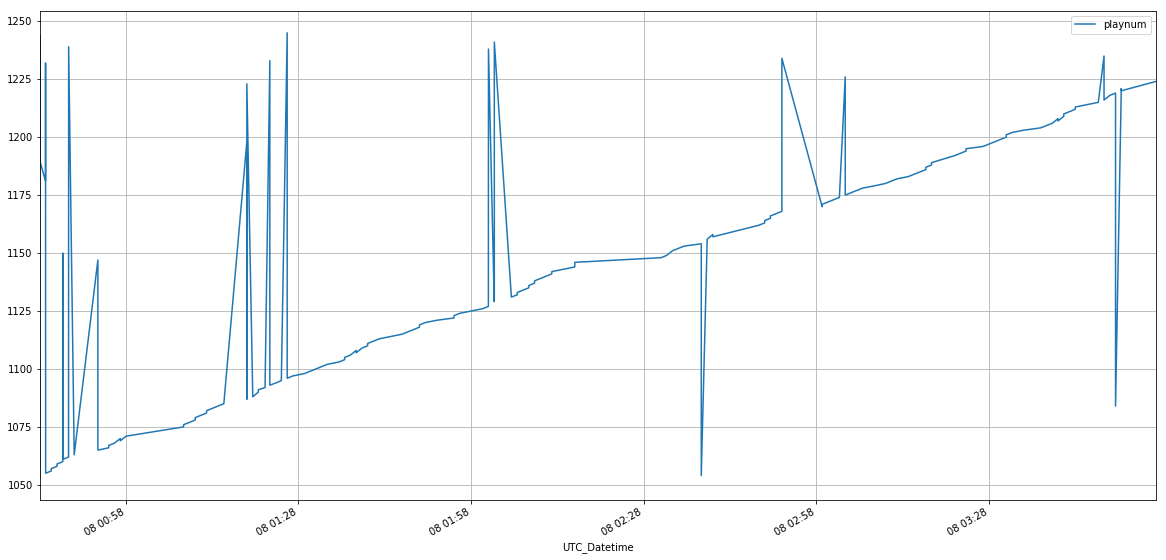

In [106]:
%matplotlib inline
df['playnum'] = df.index
df.plot(x='UTC_Datetime', y='playnum', figsize=(20,10), grid=True)

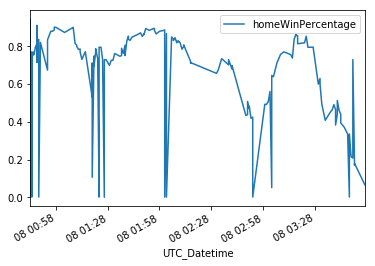

In [111]:
df[['UTC_Datetime','homeWinPercentage','Game_and_Tweet_x','Game_and_Tweet_y']].sort_values('UTC_Datetime').plot(x='UTC_Datetime', y='homeWinPercentage')

In [108]:
df2

,Game_and_Tweet,UTC_Datetime,Game Title Date
tweet_id,,,
9.059546e+17,Chiefs vs. Patriots 2017-09-07C.Santos kicks ...,2017-09-08 00:43:00,Chiefs vs. Patriots 2017-09-07
9.059548e+17,Chiefs vs. Patriots 2017-09-07(14:55) NE 12-B...,2017-09-08 00:44:01,Chiefs vs. Patriots 2017-09-07
9.059548e+17,Chiefs vs. Patriots 2017-09-07SPLIT_TWEET-T.B...,2017-09-08 00:44:01,Chiefs vs. Patriots 2017-09-07
9.059548e+17,Chiefs vs. Patriots 2017-09-07(14:49) T.Brady...,2017-09-08 00:44:02,Chiefs vs. Patriots 2017-09-07
9.059551e+17,Chiefs vs. Patriots 2017-09-07(14:14) (Shotgu...,2017-09-08 00:45:00,Chiefs vs. Patriots 2017-09-07
9.059551e+17,Chiefs vs. Patriots 2017-09-07(13:52) (No Hud...,2017-09-08 00:45:01,Chiefs vs. Patriots 2017-09-07
9.059553e+17,Chiefs vs. Patriots 2017-09-07(13:26) (No Hud...,2017-09-08 00:46:00,Chiefs vs. Patriots 2017-09-07
9.059553e+17,Chiefs vs. Patriots 2017-09-07(13:02) (No Hud...,2017-09-08 00:46:01,Chiefs vs. Patriots 2017-09-07
9.059556e+17,Chiefs vs. Patriots 2017-09-07(12:35) (No Hud...,2017-09-08 00:47:00,Chiefs vs. Patriots 2017-09-07
